# Train NeRF Grasp Metric

## Summary (April 18, 2023)

The purpose of this script is to train a neural network model to take in:

* a NeRF object model

* $n$ ray origins and directions representating fingers approaching (for now, $n = 2$)

and output:

* a grasp metric $g$ representing the quality of grasp (for now, $g \in [0, 1]$, where 0 is failed grasp and 1 is successful grasp).

To do this, we will be using the [ACRONYM dataset](https://sites.google.com/nvidia.com/graspdataset), which contains ~1.7M grasps on over 8k objects each labeled with the grasp success.

In [1]:
import wandb
import os
import h5py
import numpy as np
from localscope import localscope
import time

import random
import torch
import plotly.graph_objects as go

# Read In Config

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == "ZMQInteractiveShell":
            return True  # Jupyter notebook or qtconsole
        elif shell == "TerminalInteractiveShell":
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter

In [3]:
# Use with hydra later
# if is_notebook():
#     arguments = []
# else:
#     arguments = sys.argv[1:]
#     print(f"arguments = {arguments}")
#
# OmegaConf.register_new_resolver("eval", eval)
# with initialize(version_base=None, config_path="train_bc_config_files"):
#     cfg = compose(config_name="config", overrides=arguments)
#     print(OmegaConf.to_yaml(cfg))

# Setup Wandb

In [4]:

# time_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# run_name = f"{cfg.wandb_name}_{time_str}" if len(cfg.wandb_name) > 0 else time_str

# wandb.init(entity=cfg.wandb_entity,
#            project=cfg.wandb_project,
#            name=run_name,
#            group=cfg.wandb_group if len(cfg.wandb_group) > 0 else None,
#            job_type=cfg.wandb_job_type if len(cfg.wandb_job_type) > 0 else None,
#            config=OmegaConf.to_container(cfg),
#            reinit=True)

In [5]:


@localscope.mfc
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.set_num_threads(1)


# set_seed(cfg.RANDOM_SEED)

# Load Data From Files

In [6]:
# TODO: Need way to connect an acronym file to a nerf model nicely
nerf_model_workspace = (
    "torch-ngp/isaac_Mug_10f6e09036350e92b3f21f1137c3c347_0.0002682458/"
)
acronym_filepath = "/juno/u/tylerlum/github_repos/acronym/data/grasps/Mug_10f6e09036350e92b3f21f1137c3c347_0.0002682457830986903.h5"
assets_filepath = "/juno/u/tylerlum/github_repos/nerf_grasping/assets/objects"
urdf_filepath = os.path.join(
    assets_filepath, "urdf", "Mug_10f6e09036350e92b3f21f1137c3c347.urdf"
)
obj_filepath = os.path.join(
    assets_filepath, "meshes", "Mug", "10f6e09036350e92b3f21f1137c3c347.obj"
)

In [7]:
acronym_data = h5py.File(acronym_filepath, "r")
mesh_scale = float(acronym_data["object/scale"][()])

grasp_transforms = np.array(acronym_data["grasps/transforms"])
grasp_successes = np.array(acronym_data["grasps/qualities/flex/object_in_gripper"])

In [8]:
print(f"{grasp_transforms.shape = }")
print(f"{grasp_successes.shape = }")

grasp_transforms.shape = (2000, 4, 4)
grasp_successes.shape = (2000,)


In [9]:
LEFT_TIP_POSITION_GRASP_FRAME = np.array(
    [4.10000000e-02, -7.27595772e-12, 1.12169998e-01]
)
RIGHT_TIP_POSITION_GRASP_FRAME = np.array(
    [-4.10000000e-02, -7.27595772e-12, 1.12169998e-01]
)

In [10]:
@localscope.mfc
def position_to_transformed_positions(position, transforms):
    assert position.shape == (3,)
    assert len(transforms.shape) == 3 and transforms.shape[1:] == (4, 4)
    num_transforms = transforms.shape[0]

    transformed_positions = (transforms @ np.array([*position, 1.0]).reshape(1, 4, 1))[
        :, :3, :
    ].squeeze()
    assert transformed_positions.shape == (num_transforms, 3)
    return transformed_positions


@localscope.mfc
def position_to_transformed_positions_unvectorized(position, transforms):
    assert position.shape == (3,)
    assert len(transforms.shape) == 3 and transforms.shape[1:] == (4, 4)
    num_transforms = transforms.shape[0]

    transformed_positions = []
    for i in range(num_transforms):
        transformed_positions.append((transforms[i] @ np.array([*position, 1.0]))[:3])
    transformed_positions = np.stack(transformed_positions)
    return transformed_positions


@localscope.mfc
def run_sanity_check(position, transforms):
    # Non-vectorized
    start = time.time()
    positions_object_frame = position_to_transformed_positions_unvectorized(
        position=position, transforms=transforms
    )
    print(f"Non-vectorized took {1000 * (time.time() - start):.2f} ms")

    # Vectorized version
    start = time.time()
    positions_object_frame_2 = position_to_transformed_positions(
        position=position, transforms=transforms
    )
    print(f"Vectorized took {1000 * (time.time() - start):.2f} ms")

    assert np.max(np.abs(positions_object_frame - positions_object_frame_2)) < 1e-5
    print("Passed the test, they match!")
    return

In [11]:
run_sanity_check(position=LEFT_TIP_POSITION_GRASP_FRAME, transforms=grasp_transforms)

Non-vectorized took 18.32 ms
Vectorized took 0.42 ms
Passed the test, they match!


In [27]:
def plot_obj(obj_filepath, scale=1.0):
    # Read in the OBJ file
    with open(obj_filepath, "r") as f:
        lines = f.readlines()

    # Extract the vertex coordinates and faces from the OBJ file
    vertices = []
    faces = []
    for line in lines:
        if line.startswith("v "):
            vertex = [float(i) * scale for i in line.split()[1:4]]
            vertices.append(vertex)
        elif line.startswith("f "):
            face = [int(i.split("/")[0]) - 1 for i in line.split()[1:4]]
            faces.append(face)

    # Convert the vertex coordinates and faces to numpy arrays
    vertices = np.array(vertices)
    faces = np.array(faces)

    # Create the mesh3d trace
    mesh = go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color="lightpink",
        opacity=0.5,
        name=f"Mesh: {os.path.basename(obj_filepath)}",
    )

    # Create the layout
    layout = go.Layout(
        scene=dict(xaxis=dict(title="X"), yaxis=dict(title="Y"), zaxis=dict(title="Z"))
    )

    # Create the figure
    fig = go.Figure(data=[mesh], layout=layout)

    # Return the figure
    return fig

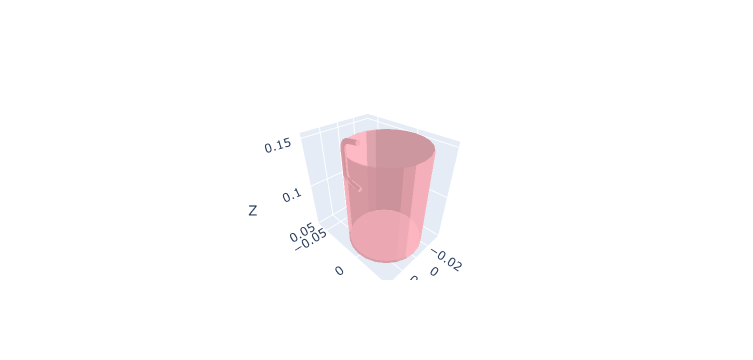

In [28]:
fig = plot_obj(obj_filepath, scale=mesh_scale)
fig.show()

In [29]:
def get_grasp_lines(grasp_transforms, grasp_successes):
    raw_left_tip = np.array([4.10000000e-02, -7.27595772e-12, 1.12169998e-01])
    raw_right_tip = np.array([-4.10000000e-02, -7.27595772e-12, 1.12169998e-01])
    raw_left_knuckle = np.array([4.10000000e-02, -7.27595772e-12, 6.59999996e-02])
    raw_right_knuckle = np.array([-4.10000000e-02, -7.27595772e-12, 6.59999996e-02])
    raw_hand_origin = np.array([0.0, 0.0, 0.0])
    left_tips = position_to_transformed_positions(
        position=raw_left_tip, transforms=grasp_transforms
    )
    right_tips = position_to_transformed_positions(
        position=raw_right_tip, transforms=grasp_transforms
    )
    left_knuckles = position_to_transformed_positions(
        position=raw_left_knuckle, transforms=grasp_transforms
    )
    right_knuckles = position_to_transformed_positions(
        position=raw_right_knuckle, transforms=grasp_transforms
    )
    hand_origins = position_to_transformed_positions(
        position=raw_hand_origin, transforms=grasp_transforms
    )

    assert (
        left_tips.shape
        == right_tips.shape
        == left_knuckles.shape
        == right_knuckles.shape
        == hand_origins.shape
        == (len(grasp_successes), 3)
    )

    grasp_lines = []
    for i, (
        left_tip,
        right_tip,
        left_knuckle,
        right_knuckle,
        hand_origin,
        grasp_success,
    ) in enumerate(zip(
        left_tips,
        right_tips,
        left_knuckles,
        right_knuckles,
        hand_origins,
        grasp_successes,
    )):
        assert grasp_success in [0, 1]
        color = "green" if grasp_success == 1 else "red"

        # left tip => left knuckle => right knuckle => right tip => right_knuckle => btwn knuckles => hand_origin
        btwn_knuckles = (left_knuckle + right_knuckle) / 2

        points = np.stack(
            [
                left_tip,
                left_knuckle,
                right_knuckle,
                right_tip,
                btwn_knuckles,
                hand_origin,
            ],
            axis=0,
        )
        assert points.shape == (6, 3)

        # Create 1 continous line per grasp
        grasp_line = go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode="lines",
            line=dict(color=color, width=5),
            name=f"Grasp {i}",
        )
        grasp_lines.append(grasp_line)
    return grasp_lines

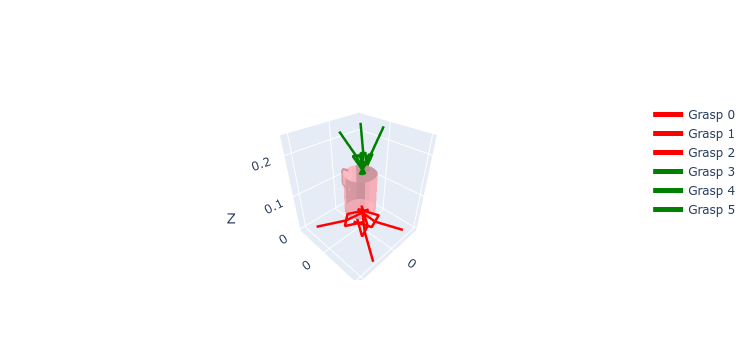

In [30]:
grasp_lines = get_grasp_lines(grasp_transforms[:6], grasp_successes[:6])
for grasp_line in grasp_lines:
    fig.add_trace(grasp_line)
fig.show()

In [16]:
def plot_obj(filepath, scale=1.0, grasp_positions=None):
    # Read in the OBJ file
    with open(filepath, "r") as f:
        lines = f.readlines()

    # Extract the vertex coordinates and faces from the OBJ file
    vertices = []
    faces = []
    for line in lines:
        if line.startswith("v "):
            vertex = [float(i) * scale for i in line.split()[1:4]]
            vertices.append(vertex)
        elif line.startswith("f "):
            face = [int(i.split("/")[0]) - 1 for i in line.split()[1:4]]
            faces.append(face)

    # Convert the vertex coordinates and faces to numpy arrays
    vertices = np.array(vertices)
    faces = np.array(faces)

    # Create the mesh3d trace
    mesh = go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        color="lightpink",
        opacity=0.5,
    )

    # Create the lines trace for the grasps, if provided
    lines = None
    if grasp_positions is not None:
        x_lines = [p[0] for p in grasp_positions]
        y_lines = [p[1] for p in grasp_positions]
        z_lines = [p[2] for p in grasp_positions]
        lines = go.Scatter3d(
            x=x_lines,
            y=y_lines,
            z=z_lines,
            mode="lines",
            line=dict(color="red", width=5),
        )

    # Create the layout
    layout = go.Layout(
        scene=dict(xaxis=dict(title="X"), yaxis=dict(title="Y"), zaxis=dict(title="Z"))
    )

    # Create the figure
    fig = go.Figure(data=[mesh])
    if lines is not None:
        fig.add_trace(lines)
    fig.update_layout(layout)

    # Return the figure
    return fig

In [17]:
fig = plot_obj(
    obj_filepath,
    scale=1.0,
    grasp_positions=[[100, 0, 550], [-100, 0, 550], [100, 100, 550]],
)

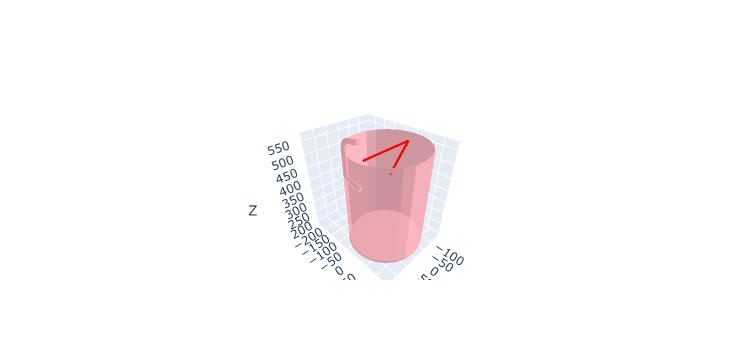

In [18]:
fig.show()

# Create Dataset

# Visualize Data

# Create Model

# Run Training

# Run Evaluation

# Visualize Results